This example notebook uses the averaging functions found ins the diff_classifier msd module to find average msd profiles over input msd datasets using precision-weighted averaging. Precision is the inverse of the standard squared error. This increases the contribution of videos that have many particles and more homogeneous datasets to the final calculated MSD.

In [1]:
import numpy as np
import numpy.ma as ma
import diff_classifier.aws as aws
import diff_classifier.msd as msd
from diff_classifier.msd import binning, precision_weight, precision_averaging, plot_all_experiments

In [2]:
folder = 'Gel_Studies/08_14_18_gel_validation'
bucket = 'ccurtis.data'
experiment = '200nm' #Used for naming purposes. Should exclude XY and well information

vids = 10
to_track = []
wells = 2
frames = 651
fps = 100.02

for num in range(1, vids+1):
    to_track.append('{}_XY{}'.format(experiment, '%02d' % num)) #As per usual, use for loops to include all experiments

print(to_track)

['200nm_XY01', '200nm_XY02', '200nm_XY03', '200nm_XY04', '200nm_XY05', '200nm_XY06', '200nm_XY07', '200nm_XY08', '200nm_XY09', '200nm_XY10']


In [3]:
geomean = {}
gSEM = {}
for sample_name in to_track:
    # Users can toggle between using pre-calculated geomean files and calculating new values by commenting out the relevant
    # lines of code within the for loop.
    #aws.download_s3('{}/geomean_{}.csv'.format(folder, sample_name), 'geomean_{}.csv'.format(sample_name), bucket_name=bucket)
    #aws.download_s3('{}/geoSEM_{}.csv'.format(folder, sample_name), 'geoSEM_{}.csv'.format(sample_name), bucket_name=bucket)
    #geomean[sample_name] = np.genfromtxt('geomean_{}.csv'.format(sample_name))
    #gSEM[sample_name] = np.genfromtxt('geoSEM_{}.csv'.format(sample_name))
    
    aws.download_s3('{}/msd_{}.csv'.format(folder, sample_name), 'msd_{}.csv'.format(sample_name), bucket_name=bucket)
    geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=0.07, fps=fps,
                                                                 remote_folder=folder, bucket=bucket)
    print('Done with {}'.format(sample_name))

Done with 200nm_XY01
Done with 200nm_XY02
Done with 200nm_XY03
Done with 200nm_XY04
Done with 200nm_XY05
Done with 200nm_XY06
Done with 200nm_XY07
Done with 200nm_XY08
Done with 200nm_XY09
Done with 200nm_XY10


In [4]:
slices, bins, well_names = binning(to_track, wells = wells, prefix=experiment)
geo_slices = {}
gSEM_slices = {}

w_slices = {}
wo_slices = {}
w_holder = {}
wh = {}
gh = {}

for key in bins:
    print(key)
    wo_slices[key], wh[key] = precision_weight(bins[key], gSEM)
    geodata = precision_averaging(bins[key], geomean, gSEM, wo_slices[key],
                                                            bucket=bucket, folder=folder, experiment=key)
    geo_slices[key] = geodata.geomean
    gSEM_slices[key] = geodata.geostd

for key in geo_slices:
    geo_slices[key][geo_slices[key]==0.0] = np.nan
    gSEM_slices[key][gSEM_slices[key]==0.0] = np.nan
    
    geo_slices[key] = ma.masked_invalid(geo_slices[key])
    gSEM_slices[key] = ma.masked_invalid(gSEM_slices[key])
    
weights, wh1 = precision_weight(well_names, gSEM_slices)
geodata1 = precision_averaging(well_names, geo_slices, gSEM_slices, weights, bucket=bucket, folder=folder, experiment=experiment)

200nm_W0
200nm_W1


Note that in cases where two or more averaging steps are needed (for instance, if the user takes 5 videos per well with a total of four wells), averaging steps can be performed consecutively. the msd.binning function is a helpful tool by defining bins over which to average for multi-step averaging.

In [ ]:
well_names

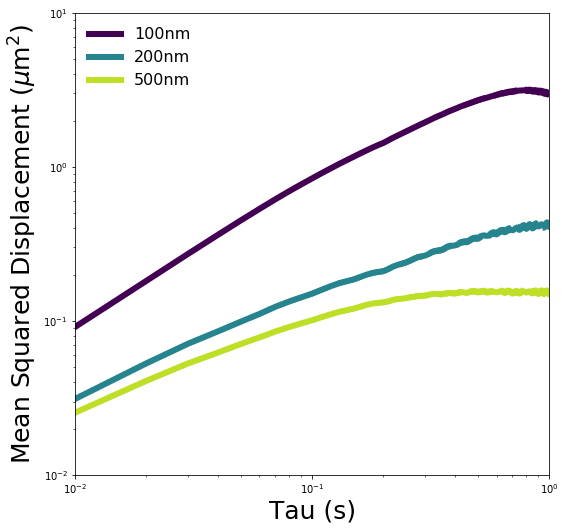

In [7]:
msd.plot_all_experiments(['100nm', '200nm', '500nm'], yrange=(10**-2, 10**1), bucket=bucket, folder=folder)

In [ ]:
import pandas as pd
filename = 'features_test_01.csv'
folder = 'test_files'
aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name='nancelab.publicfiles')

fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')

In [ ]:
tgroups = {}
tgroups[0] = fstats[fstats['frames']<100]
tgroups[1] = fstats[fstats['frames']<300]
tgroups[1] = tgroups[1][tgroups[1]['frames']>100]
tgroups[2] = fstats[300<fstats['frames']]

In [ ]:
import diff_classifier.features as ft
%matplotlib inline

In [ ]:
ft.feature_violin(tgroups, feature='alpha', ylim=[0, 4], majorticks = np.linspace(0, 4, 11))